In [5]:
from scipy.ndimage import rotate
import numpy as np
import nibabel as nib
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import sys
sys.path.append("../../STalign") 
import STalign
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

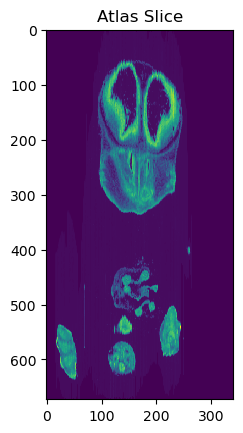

In [6]:
#vol,hdr = nrrd.read('../E13-5_MRI_34um/atlasVolume.nrrd',index_order='F')
import SimpleITK as sitk
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
A = ct_scan.transpose(2,1,0) 
slice = 215
theta_deg = 0
fig,ax = plt.subplots()
ax.imshow(rotate(A[slice], angle=theta_deg),interpolation='none')
ax.set_title('Atlas Slice')
J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:280,:] 
YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 

In [29]:
fname = '../visium_data/sccanals28/A1_tissue_positions.csv'
df1 = pd.read_csv(fname)
df1=df1[df1["in_tissue"]==1]
df1["pxl_row_in_fullres"]=df1["pxl_row_in_fullres"]/4.96
df1["pxl_col_in_fullres"]=df1["pxl_col_in_fullres"]/4.96
df1=df1[df1["pxl_col_in_fullres"]>400]
df1=df1[df1["pxl_col_in_fullres"]<3000]
df1=df1[df1["pxl_row_in_fullres"]>1500]
df1=df1[df1["pxl_row_in_fullres"]<4200]
df1["pxl_col_in_fullres"]=+400-(df1["pxl_col_in_fullres"]-2600)



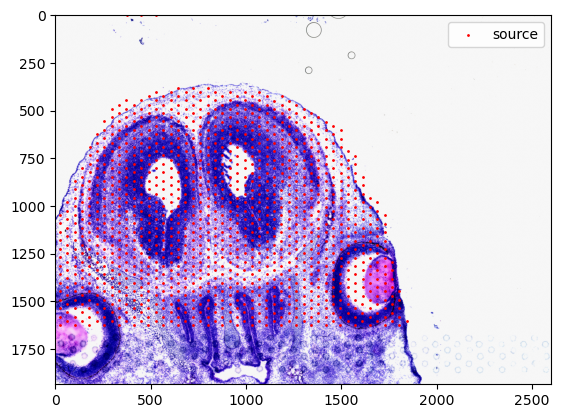

In [31]:
# get cell centroid coordinates
xI = (np.array(df1['pxl_col_in_fullres'])).astype(np.int32)
yI = (np.array(df1['pxl_row_in_fullres']-1500)).astype(np.int32)
test = Vnorm.transpose(2,0,1)
test=test[0:200,1500:4200,400:3000]
# plot
fig,ax = plt.subplots()
ax.imshow(I_A1.transpose(1,2,0))
ax.scatter(xI,yI,c='red',s=1,alpha=1, label='source')
ax.legend(markerscale = 1)
ax.set_aspect('equal')

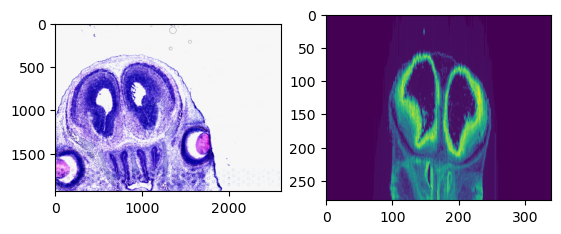

In [9]:

J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:280,:] 
image_file = '../visium_data/sccanals28/A1_mod.jpg'
V = plt.imread(image_file)
Vnorm = STalign.normalize(V)
I_A1 = Vnorm.transpose(2,0,1)
I_A1=np.flip(I_A1[0:200,1500:4200,400:3000],axis=2)
YI= np.array(range(I_A1.shape[1]))*1. 
XI = np.array(range(I_A1.shape[2]))*1. 
fig,ax = plt.subplots(1,2)
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))
ax[0].imshow((I_A1.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
fig.canvas.draw()  
np.savez('../visium_data/sccanals28/model_A1_1',x=XI,y=YI,I=I_A1)
np.savez('../visium_data/sccanals28/visum_A1_1', x=XJ,y=YJ,I=J[0:1])

Text(0.5, 1.0, 'target with pointsJ')

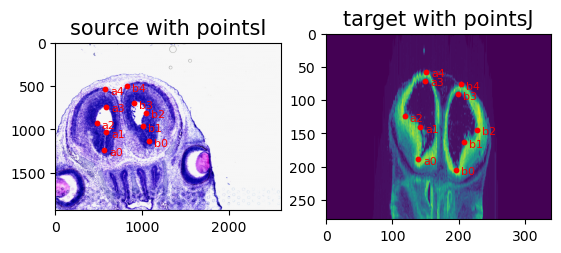

In [15]:
pointsIlist_A1 = np.load('../visium_data/sccanals28/model_A1_1_points.npy', allow_pickle=True).tolist()
pointsJlist_A1 = np.load('../visium_data/sccanals28/visum_A1_1_points.npy', allow_pickle=True).tolist()
pointsI_A1 = []
pointsJ_A1 = []
for i in pointsIlist_A1.keys():
    for j in range(len(pointsIlist_A1[i])):
        pointsI_A1.append([pointsIlist_A1[i][j][1], pointsIlist_A1[i][j][0]])
for i in pointsJlist_A1.keys():
    for j in range(len(pointsJlist_A1[i])):
        pointsJ_A1.append([pointsJlist_A1[i][j][1], pointsJlist_A1[i][j][0]])
J = np.vstack((J,J,J)) 
pointsI_A1 = np.array(pointsI_A1)
pointsJ_A1 = np.array(pointsJ_A1)
fig,ax = plt.subplots(1,2)
ax[0].imshow((I_A1.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
ax[0].scatter(pointsI_A1[:,1],pointsI_A1[:,0], c='red', s=10)
ax[1].scatter(pointsJ_A1[:,1],pointsJ_A1[:,0], c='red', s=10)    
for i in pointsIlist_A1.keys():
    for j in range(len(pointsIlist_A1[i])):
        ax[0].text(pointsIlist_A1[i][j][0], pointsIlist_A1[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist_A1.keys():
    for j in range(len(pointsJlist_A1[i])):
        ax[1].text(pointsJlist_A1[i][j][0], pointsJlist_A1[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

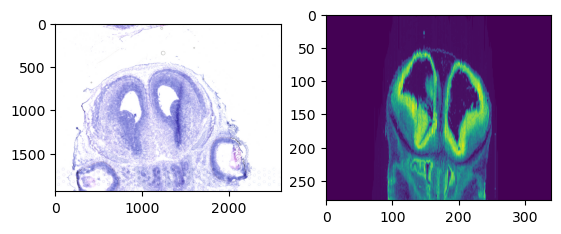

In [17]:
slice = 225
J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:280,:] 
image_file = '../visium_data/sccanals28/B1_mod.jpg'
V = plt.imread(image_file)
Vnorm = STalign.normalize(V)
I_B1 = Vnorm.transpose(2,0,1)
I_B1=I_B1[0:200,1500:4200,400:3000]
I_B1=np.flip(I_B1,axis=2)
YI= np.array(range(I_B1.shape[1]))*1. 
XI = np.array(range(I_B1.shape[2]))*1. 
fig,ax = plt.subplots(1,2)
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))
ax[0].imshow((I_B1.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
fig.canvas.draw()  
np.savez('../visium_data/sccanals28/model_B1_1',x=XI,y=YI,I=I_B1)
np.savez('../visium_data/sccanals28/visum_B1_1', x=XJ,y=YJ,I=J[0:1])

Text(0.5, 1.0, 'target with pointsJ')

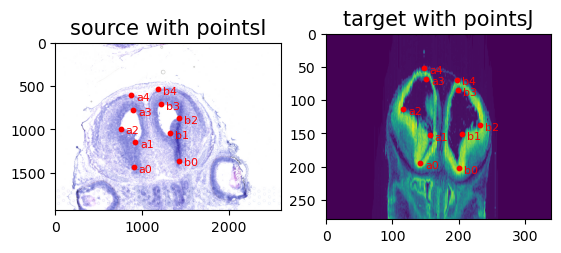

In [19]:
pointsIlist_B1 = np.load('../visium_data/sccanals28/model_B1_1_points.npy', allow_pickle=True).tolist()
pointsJlist_B1 = np.load('../visium_data/sccanals28/visum_B1_1_points.npy', allow_pickle=True).tolist()
pointsI_B1 = []
pointsJ_B1 = []
for i in pointsIlist_B1.keys():
    for j in range(len(pointsIlist_B1[i])):
        pointsI_B1.append([pointsIlist_B1[i][j][1], pointsIlist_B1[i][j][0]])
for i in pointsJlist_B1.keys():
    for j in range(len(pointsJlist_B1[i])):
        pointsJ_B1.append([pointsJlist_B1[i][j][1], pointsJlist_B1[i][j][0]])
J = np.vstack((J,J,J)) 
pointsI_B1 = np.array(pointsI_B1)
pointsJ_B1 = np.array(pointsJ_B1)
fig,ax = plt.subplots(1,2)
ax[0].imshow((I_B1.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
ax[0].scatter(pointsI_B1[:,1],pointsI_B1[:,0], c='red', s=10)
ax[1].scatter(pointsJ_B1[:,1],pointsJ_B1[:,0], c='red', s=10)    
for i in pointsIlist_B1.keys():
    for j in range(len(pointsIlist_B1[i])):
        ax[0].text(pointsIlist_B1[i][j][0], pointsIlist_B1[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist_B1.keys():
    for j in range(len(pointsJlist_B1[i])):
        ax[1].text(pointsJlist_B1[i][j][0], pointsJlist_B1[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

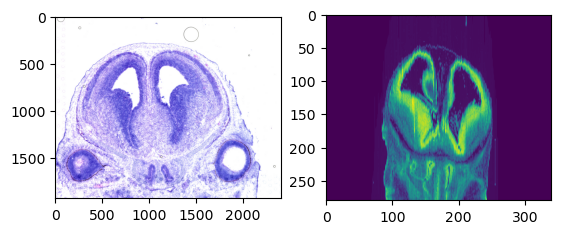

In [21]:
slice = 235
J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:280,:] 
image_file = '../visium_data/sccanals28/C1_mod.jpg'
V = plt.imread(image_file)
Vnorm = STalign.normalize(V)
I_C1 = Vnorm.transpose(2,0,1)
I_C1=I_C1[0:200,1500:4200,1000:3400]
I_C1=np.flip(I_C1,axis=2)
YI= np.array(range(I_C1.shape[1]))*1. 
XI = np.array(range(I_C1.shape[2]))*1. 
fig,ax = plt.subplots(1,2)
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))
ax[0].imshow((I_C1.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
fig.canvas.draw()  
np.savez('../visium_data/sccanals28/model_C1_1',x=XI,y=YI,I=I_C1)
np.savez('../visium_data/sccanals28/visum_C1_1', x=XJ,y=YJ,I=J[0:1])

Text(0.5, 1.0, 'target with pointsJ')

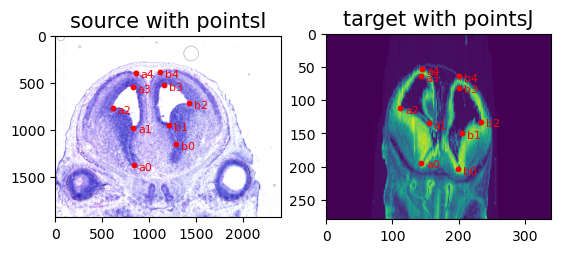

In [25]:
pointsIlist_C1 = np.load('../visium_data/sccanals28/model_C1_1_points.npy', allow_pickle=True).tolist()
pointsJlist_C1 = np.load('../visium_data/sccanals28/visum_C1_1_points.npy', allow_pickle=True).tolist()
pointsI_C1 = []
pointsJ_C1 = []
for i in pointsIlist_C1.keys():
    for j in range(len(pointsIlist_C1[i])):
        pointsI_C1.append([pointsIlist_C1[i][j][1], pointsIlist_C1[i][j][0]])
for i in pointsJlist_C1.keys():
    for j in range(len(pointsJlist_C1[i])):
        pointsJ_C1.append([pointsJlist_C1[i][j][1], pointsJlist_C1[i][j][0]])
J = np.vstack((J,J,J)) 
pointsI_C1 = np.array(pointsI_C1)
pointsJ_C1 = np.array(pointsJ_C1)
fig,ax = plt.subplots(1,2)
ax[0].imshow((I_C1.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
ax[0].scatter(pointsI_C1[:,1],pointsI_C1[:,0], c='red', s=10)
ax[1].scatter(pointsJ_C1[:,1],pointsJ_C1[:,0], c='red', s=10)    
for i in pointsIlist_C1.keys():
    for j in range(len(pointsIlist_C1[i])):
        ax[0].text(pointsIlist_C1[i][j][0], pointsIlist_C1[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist_C1.keys():
    for j in range(len(pointsJlist_C1[i])):
        ax[1].text(pointsJlist_C1[i][j][0], pointsJlist_C1[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

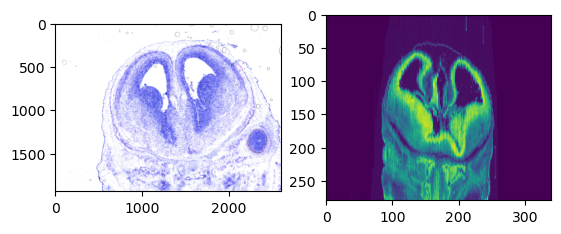

In [27]:
slice = 245
J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:280,:] 
image_file = '../visium_data/sccanals28/D1_mod.jpg'
V = plt.imread(image_file)
Vnorm = STalign.normalize(V)
I_D1 = Vnorm.transpose(2,0,1)
I_D1=I_D1[0:200,1500:4200,400:3000]
I_D1=np.flip(I_D1,axis=2)
YI= np.array(range(I_D1.shape[1]))*1. 
XI = np.array(range(I_D1.shape[2]))*1. 
fig,ax = plt.subplots(1,2)
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))
ax[0].imshow((I_D1.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
fig.canvas.draw()  
np.savez('../visium_data/sccanals28/model_D1_1',x=XI,y=YI,I=I_D1)
np.savez('../visium_data/sccanals28/visum_D1_1', x=XJ,y=YJ,I=J[0:1])

Text(0.5, 1.0, 'target with pointsJ')

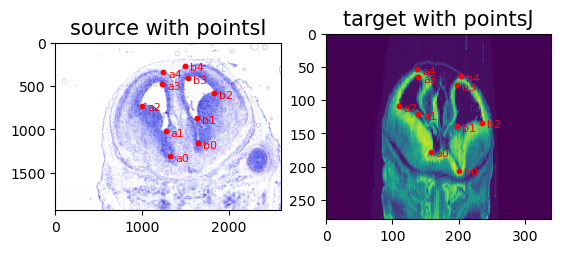

In [31]:
pointsIlist_D1 = np.load('../visium_data/sccanals28/model_D1_1_points.npy', allow_pickle=True).tolist()
pointsJlist_D1 = np.load('../visium_data/sccanals28/visum_D1_1_points.npy', allow_pickle=True).tolist()
pointsI_D1 = []
pointsJ_D1 = []
for i in pointsIlist_D1.keys():
    for j in range(len(pointsIlist_D1[i])):
        pointsI_D1.append([pointsIlist_D1[i][j][1], pointsIlist_D1[i][j][0]])
for i in pointsJlist_D1.keys():
    for j in range(len(pointsJlist_D1[i])):
        pointsJ_D1.append([pointsJlist_D1[i][j][1], pointsJlist_D1[i][j][0]])
J = np.vstack((J,J,J)) 
pointsI_D1 = np.array(pointsI_D1)
pointsJ_D1 = np.array(pointsJ_D1)
fig,ax = plt.subplots(1,2)
ax[0].imshow((I_D1.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
ax[0].scatter(pointsI_D1[:,1],pointsI_D1[:,0], c='red', s=10)
ax[1].scatter(pointsJ_D1[:,1],pointsJ_D1[:,0], c='red', s=10)    
for i in pointsIlist_D1.keys():
    for j in range(len(pointsIlist_D1[i])):
        ax[0].text(pointsIlist_D1[i][j][0], pointsIlist_D1[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist_D1.keys():
    for j in range(len(pointsJlist_D1[i])):
        ax[1].text(pointsJlist_D1[i][j][0], pointsJlist_D1[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)